# Фаза 2 • Неделя 10 • Понедельник
## Обработка естественного языка
### Рекуррентные нейронные сети • RNN & LSTM

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install torchutils

In [ ]:
!pip install torchmetrics

In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re
import string
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchutils as tu
from torchmetrics.classification import BinaryAccuracy

In [5]:
from google.colab import files
uploaded = files.upload()

Saving src.zip to src.zip


In [6]:
import zipfile
import io

file_name = 'src.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content')

In [7]:
import sys
from dataclasses import dataclass
from time import time
sys.path.append('/content/src')
from src.train_rnn import train
from src.rnn_preprocessing import preprocess_single_string

In [9]:
df = pd.read_csv('/content/imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
def data_preprocessing(text: str) -> str:
    """preprocessing string: lowercase, removing html-tags, punctuation and stopwords

    Args:
        text (str): input string for preprocessing

    Returns:
        str: preprocessed string
    """

    text = text.lower()
    text = re.sub('<.*?>', '', text) # html tags
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)

In [11]:
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)

sorted_words = count_words.most_common()


In [12]:
def get_words_by_freq(sorted_words: list, n: int = 10) -> list:
    return list(filter(lambda x: x[1] > n, sorted_words))

In [13]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [14]:
reviews_int = []
for text in df['cleaned_reviews']:

    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)

In [15]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [16]:
review_len = [len(x) for x in reviews_int]
df['Review len'] = review_len
df.head()

,review,sentiment,cleaned_reviews,Review len
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,168
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,84
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,86
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,67
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,125


In [17]:
def padding(review_int: list, seq_len: int) -> np.array:
    """Make left-sided padding for input list of tokens

    Args:
        review_int (list): input list of tokens
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros

    Returns:
        np.array: padded sequences
    """
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

In [18]:
def preprocess_single_string(input_string: str, seq_len: int, vocab_to_int: dict = vocab_to_int) -> list:
    """Function for all preprocessing steps on a single string

    Args:
        input_string (str): input single string for preprocessing
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros
        vocab_to_int (dict, optional): word corpus {'word' : int index}. Defaults to vocab_to_int.

    Returns:
        list: preprocessed string
    """

    preprocessed_string = data_preprocessing(input_string)
    result_list = []
    for word in preprocessed_string.split():
        try:
            result_list.append(vocab_to_int[word])
        except KeyError as e:
            print(f'{e}: not in dictionary!')
    result_padded = padding([result_list], seq_len)[0]

    return torch.tensor(result_padded)

In [19]:
SEQ_LEN = 32
features = padding(reviews_int, SEQ_LEN)
print(features[3, :])

[  572   124   136    37   327  3493  1071   124   908  4207   630   883
 13189     1  7877  1794  1248   958  3493   933   302  5835   380 83236
    19   215    70    23     2   110   993   653]


In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)

In [21]:

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))


BATCH_SIZE = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [22]:
VOCAB_SIZE = len(vocab_to_int)+1

In [23]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

In [24]:
device='cpu'

PyTorch: [docs](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

#### Задание 1

Создай модель со следующими параметрами и примени `get_model_summary`:
- два RNN-слоя (это параметр в слое, а не отдельные компоненты сети)
- 32 - размер hidden state
- 64 - размер эмбеддинг-слоя

In [25]:
@dataclass
class ConfigRNN:
    vocab_size: int
    device: str
    n_layers: int
    embedding_dim: int
    hidden_size: int
    seq_len: int
    bidirectional: bool or int

In [26]:
net_config = ConfigRNN(
    vocab_size=len(vocab_to_int) + 1,
    device="cpu",
    n_layers=2,
    embedding_dim=64,
    hidden_size=32,
    seq_len=SEQ_LEN,
    bidirectional=False,
)
net_config

ConfigRNN(vocab_size=222610, device='cpu', n_layers=2, embedding_dim=64, hidden_size=32, seq_len=32, bidirectional=False)

In [27]:
class RNNNet(nn.Module):
    """
    vocab_size: int, размер словаря (аргумент embedding-слоя)
    emb_size:   int, размер вектора для описания каждого элемента последовательности
    hidden_dim: int, размер вектора скрытого состояния, default 0
    batch_size: int, размер batch
    """

    def __init__(self, rnn_conf=net_config) -> None:
        super().__init__()
        self.rnn_conf = rnn_conf
        self.seq_len = rnn_conf.seq_len
        self.emb_size = rnn_conf.embedding_dim
        self.hidden_dim = rnn_conf.hidden_size
        self.n_layers = rnn_conf.n_layers
        self.vocab_size = rnn_conf.vocab_size
        self.bidirectional = bool(rnn_conf.bidirectional)

        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
        self.rnn_cell = nn.RNN(
            input_size=self.emb_size,
            hidden_size=self.hidden_dim,
            batch_first=True,
            bidirectional=self.bidirectional,
            num_layers=self.n_layers,
        )
        self.bidirect_factor = 2 if self.bidirectional == 1 else 1
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_dim * self.seq_len * self.bidirect_factor, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"rnn_{direction}_{self.n_layers}"

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x.to(self.rnn_conf.device))
        output, _ = self.rnn_cell(x)  # Забираем hidden states со всех промежуточных состояний, второй выход отправляем в _
        output = output.contiguous().view(output.size(0), -1)
        out = self.linear(output)
        return out


model_rnn = RNNNet(net_config)
tu.get_model_summary(model_rnn, sample_x.to(net_config.device))

Layer                  Kernel         Output        Params          FLOPs
0_embedding         [64, 222610]   [32, 32, 64]   14,247,040        1,024
1_rnn_cell                     -   [32, 32, 32]        5,248   63,242,240
2_linear.Linear_0     [1024, 16]       [32, 16]       16,400    1,048,064
3_linear.Tanh_1                -       [32, 16]            0        2,560
4_linear.Linear_2        [16, 1]        [32, 1]           17          992
Total params: 14,268,705
Trainable params: 14,268,705
Non-trainable params: 0
Total FLOPs: 64,294,880 / 64.29 MFLOPs
-------------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.76
Params size (MB): 54.43
Estimated Total Size (MB): 55.20


Задай функцию потерь, оптимизаторы и реализуй обучающий цикл.
В цикле:
* сохраняй промежуточные веса модели, чтобы потом не терять время на новом обучении
* замеряй время обучения текущей модели для сравнения с LSTM-моделью
* зафиксируй число эпох: 7-10 (в зависимости от ресурсов компьютера)

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters())
metric = BinaryAccuracy()

# цикл обучения и валидации

train_losses, val_losses, train_metric, val_metric, rnn_time = train(
    epochs=8,
    model=model_rnn,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer_rnn,
    rnn_conf=net_config,
    criterion=criterion,
    metric=metric,
)

Epoch 1
train_loss : 0.6033 val_loss : 0.5298
train_accuracy : 0.66 val_accuracy : 0.73
Epoch 2
train_loss : 0.4387 val_loss : 0.4724
train_accuracy : 0.80 val_accuracy : 0.77
Epoch 3
train_loss : 0.3249 val_loss : 0.4942
train_accuracy : 0.87 val_accuracy : 0.78
Epoch 4
train_loss : 0.2349 val_loss : 0.5415
train_accuracy : 0.91 val_accuracy : 0.78
Epoch 5
train_loss : 0.1600 val_loss : 0.6188
train_accuracy : 0.95 val_accuracy : 0.78
Epoch 6
train_loss : 0.1054 val_loss : 0.7207
train_accuracy : 0.97 val_accuracy : 0.77
Epoch 7
train_loss : 0.0686 val_loss : 0.8269
train_accuracy : 0.98 val_accuracy : 0.78
Epoch 8
train_loss : 0.0490 val_loss : 0.9196
train_accuracy : 0.99 val_accuracy : 0.77


Распечатай кривые обучения и изменения метрики.

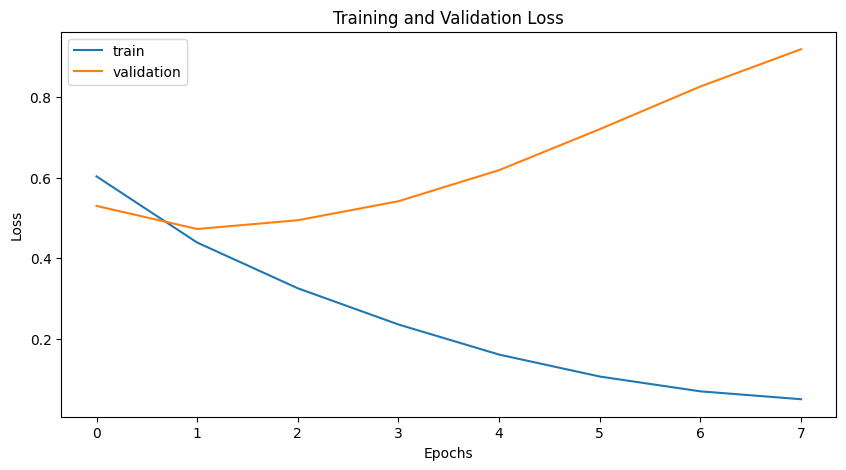

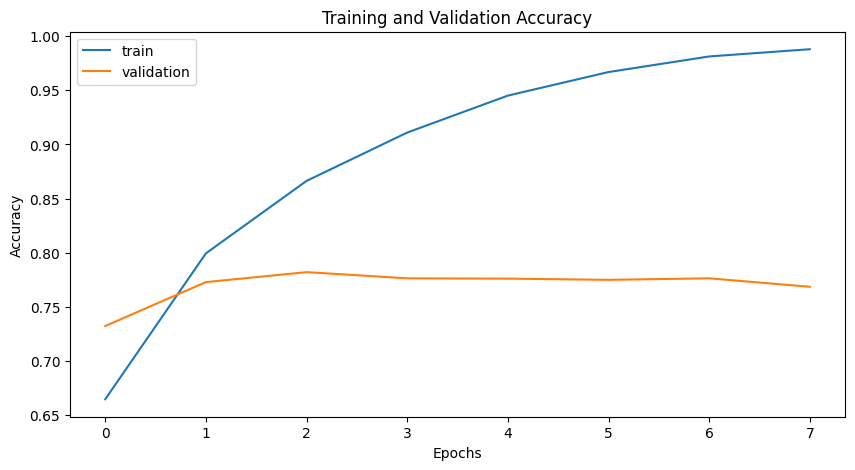

In [29]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_metric, label='train')
plt.plot(val_metric, label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Сохрани модель и историю изменения лоссов и метрик.

In [32]:
import pickle

torch.save(model_rnn.state_dict(), 'rnn_sentiment_analysis.pth')
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracy': train_metric,
    'val_accuracy': val_metric,
    'rnn_time': rnn_time
}

with open('rnn_sentiment_history.pkl', 'wb') as f:
    pickle.dump(history, f)

#### Задание 2

Создай двунаправленную двуслойную LSTM-сеть и реши задачу классификации.

Распечатай кривые обучения обеих моделей и значения метрик во время обучения. Примерный результат должен выглядеть так (с поправкой на твою архитектуру в заголовке):

![](aux/10-01-results.png)

In [35]:
class LSTMNet(nn.Module):
    def __init__(self, rnn_conf=net_config) -> None:
        super().__init__()
        self.rnn_conf = rnn_conf
        self.seq_len = rnn_conf.seq_len
        self.emb_size = rnn_conf.embedding_dim
        self.hidden_dim = rnn_conf.hidden_size
        self.n_layers = rnn_conf.n_layers
        self.vocab_size = rnn_conf.vocab_size
        self.bidirectional = bool(rnn_conf.bidirectional)

        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
        self.lstm_cell = nn.LSTM(
            input_size=self.emb_size,
            hidden_size=self.hidden_dim,
            batch_first=True,
            bidirectional=self.bidirectional,
            num_layers=self.n_layers,
        )
        self.bidirect_factor = 2 if self.bidirectional == 1 else 1
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_dim * self.seq_len * self.bidirect_factor, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"lstm_{direction}_{self.n_layers}"

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x.to(self.rnn_conf.device))
        output, _ = self.lstm_cell(x)  # Забираем hidden states со всех промежуточных состояний, второй выход отправляем в _
        output = output.contiguous().view(output.size(0), -1)
        out = self.linear(output)
        return out


In [36]:
model_lstm = LSTMNet(net_config)
tu.get_model_summary(model_lstm, sample_x.to(net_config.device))

Layer                  Kernel         Output        Params           FLOPs
0_embedding         [64, 222610]   [32, 32, 64]   14,247,040         1,024
1_lstm_cell                    -   [32, 32, 32]       20,992   215,613,440
2_linear.Linear_0     [1024, 16]       [32, 16]       16,400     1,048,064
3_linear.Tanh_1                -       [32, 16]            0         2,560
4_linear.Linear_2        [16, 1]        [32, 1]           17           992
Total params: 14,284,449
Trainable params: 14,284,449
Non-trainable params: 0
Total FLOPs: 216,666,080 / 216.67 MFLOPs
--------------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.76
Params size (MB): 54.49
Estimated Total Size (MB): 55.26


In [38]:
criterion = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters())
metric = BinaryAccuracy()
train_losses_lstm, val_losses_lstm, train_metric_lstm, val_metric_lstm, lstm_time = train(
    epochs=8,
    model=model_lstm,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer_lstm,
    rnn_conf=net_config,
    criterion=criterion,
    metric=metric,
)

Epoch 1
train_loss : 0.4885 val_loss : 0.4663
train_accuracy : 0.76 val_accuracy : 0.78
Epoch 2
train_loss : 0.3677 val_loss : 0.4427
train_accuracy : 0.84 val_accuracy : 0.80
Epoch 3
train_loss : 0.2592 val_loss : 0.4841
train_accuracy : 0.90 val_accuracy : 0.79
Epoch 4
train_loss : 0.1601 val_loss : 0.5640
train_accuracy : 0.94 val_accuracy : 0.79
Epoch 5
train_loss : 0.0851 val_loss : 0.7618
train_accuracy : 0.97 val_accuracy : 0.78
Epoch 6
train_loss : 0.0507 val_loss : 0.8322
train_accuracy : 0.99 val_accuracy : 0.78
Epoch 7
train_loss : 0.0333 val_loss : 0.9667
train_accuracy : 0.99 val_accuracy : 0.78
Epoch 8
train_loss : 0.0258 val_loss : 1.0422
train_accuracy : 0.99 val_accuracy : 0.77


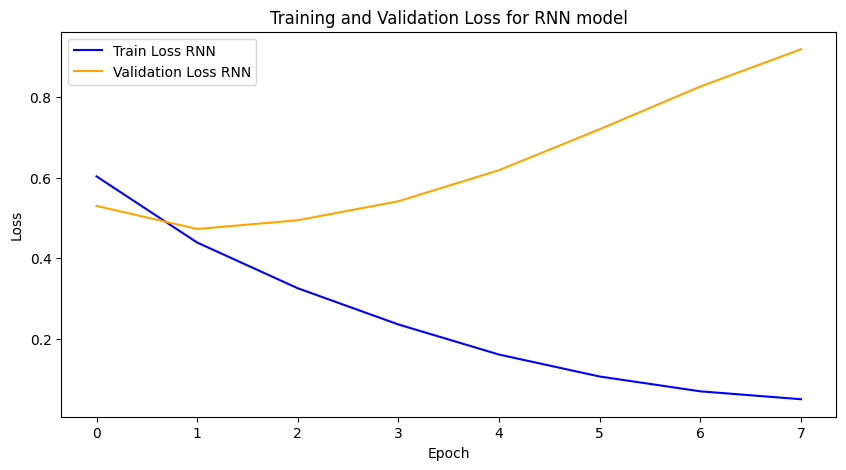

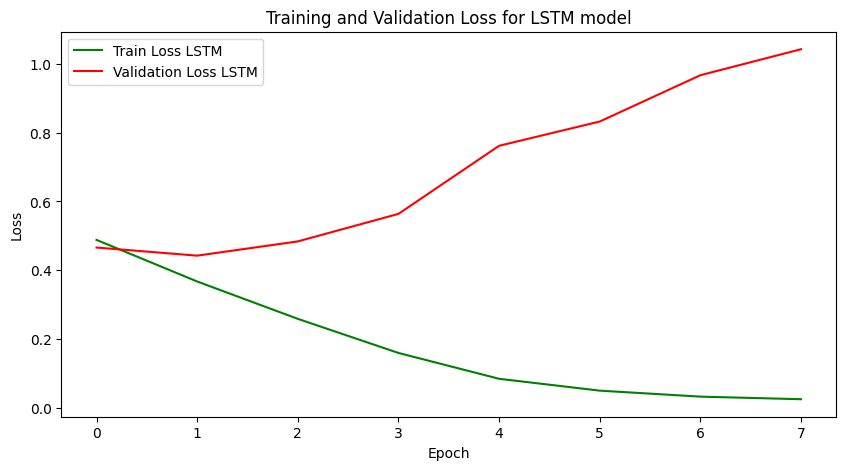

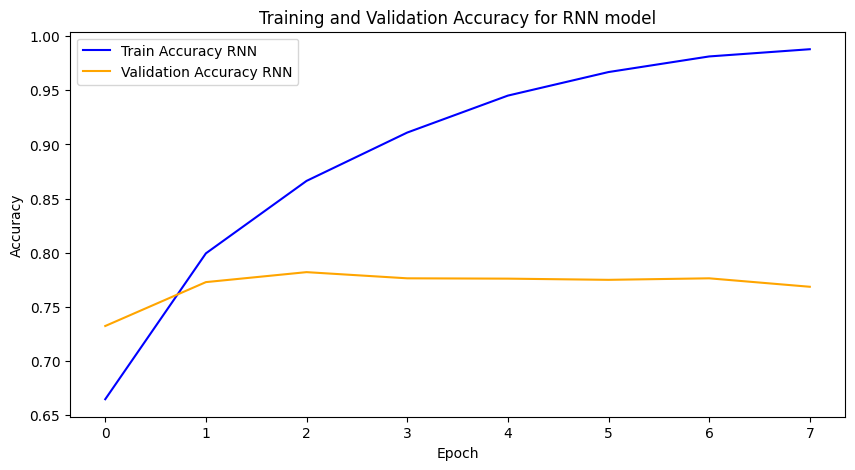

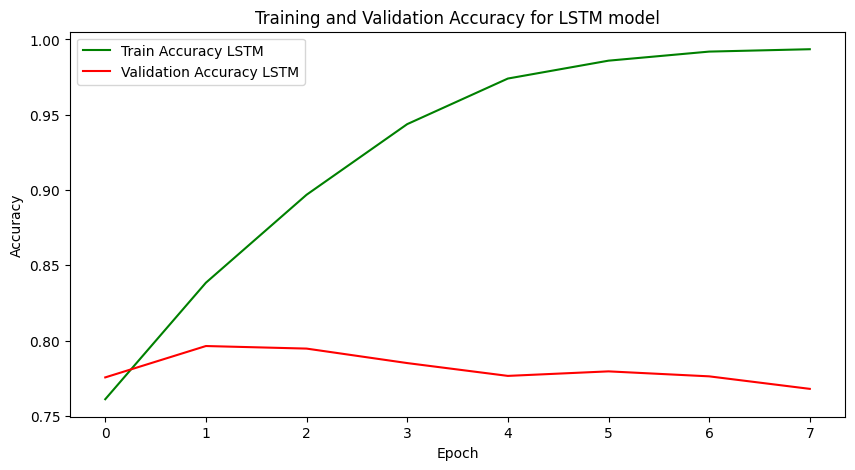

In [43]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss RNN', color='blue')
plt.plot(val_losses, label='Validation Loss RNN', color='orange')
plt.legend()
plt.title('Training and Validation Loss for RNN model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_losses_lstm, label='Train Loss LSTM', color='green')
plt.plot(val_losses_lstm, label='Validation Loss LSTM', color='red')
plt.legend()
plt.title('Training and Validation Loss for LSTM model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_metric, label='Train Accuracy RNN', color='blue')
plt.plot(val_metric, label='Validation Accuracy RNN', color='orange')
plt.legend()
plt.title('Training and Validation Accuracy for RNN model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_metric_lstm, label='Train Accuracy LSTM', color='green')
plt.plot(val_metric_lstm, label='Validation Accuracy LSTM', color='red')
plt.legend()
plt.title('Training and Validation Accuracy for LSTM model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Задание 3

Реализуй функцию, которая принимает на вход текстовое сообщение и классифицирует его обученной моделью.

```
def predict_sentence(text: str, model: nn.Module) -> str:
    
    ...

    return result
```

In [40]:
def predict_sentence(text: str, model: nn.Module) -> str:
    preprocessed_text = preprocess_single_string(text, SEQ_LEN)
    preprocessed_text = preprocessed_text.view(1, -1) # reshaping for batch size of 1
    with torch.no_grad():
        output = model(preprocessed_text)
        prediction = torch.sigmoid(output).item()

    return "positive" if prediction > 0.5 else "negative"


In [42]:
# Example usage
text = "'Parasite' is a riveting and thought-provoking film that delves \
into the complex dynamics of class struggle. The storytelling is masterful, \
with twists and turns that keep you on the edge of your seat until the very end. \
The acting is top-notch, with each character bringing depth and nuance to the screen. \
Director Bong Joon-ho has crafted a truly unforgettable cinematic experience that will linger \
in your mind long after the credits have rolled. 'Parasite' is a must-see film that will \
challenge your perceptions and leave you questioning the inequalities present in our society."
prediction = predict_sentence(text, model_lstm)
print(prediction)

positive


❗️ Сделай push на гитхаб!

In [ ]:
# code

#### Задание 4

Создай telegram-бота, который принимает на вход пользовательское сообщение и классифицирует его.